# 実装

## 環境配置

```
conda create -n nlp_workshop
sudo apt install python3-pip
pip install -r requirements.txt
```
```
!pip install transformers
!pip install datasets
!pip install fugashi
!pip install ipadic
!pip install torch
!pip install accelerate -U
```

## サンプルデータ

### サンプルデータの取得

Hugging Faceのには色々なデータセットが用意されております。例として、多言語のセンチメントデータセットのうち、日本語のサブセットを使用します。

以下を実行しデータセットを取得します。

In [3]:
from datasets import load_dataset
dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

/home/lyuzeyu/anaconda3/envs/nlp_workshop/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### サンプルデータの確認

取得したデータセットの中身を確認します。

- データセットはこのようにtrain, validation, testに分かれています。
- ['text', 'source', 'label']といった情報を持っています。

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
})

In [5]:
dataset.set_format(type="pandas")
train_df = dataset["train"][:]
train_df.head(5)

,text,source,label
0,普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...,amazon_reviews_multi,2
1,十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...,amazon_reviews_multi,2
2,見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後いつも通りゼンマイを巻いていたら...,amazon_reviews_multi,2
3,よくある部分での断線はしませんでした ただiphoneとの接続部で接触不良、折れました ip...,amazon_reviews_multi,2
4,プラモデルの塗装剥離に使う為に購入 届いて早速使ってみた 結果 １ヶ月経っても未だに剥離出来...,amazon_reviews_multi,2


各ラベルの意味につい確認すると、$0$,$1$,$2$がそれぞれ'positive','neutral','negative'に割り当てられていることが分かります。

ラベルの内訳も確認します。

In [6]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}

<Axes: title={'center': 'Train Dataset'}, ylabel='label'>

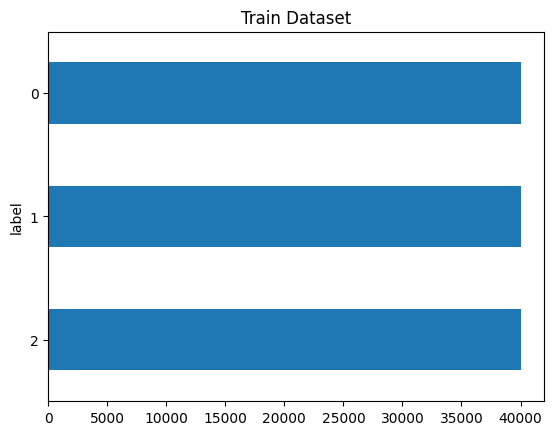

In [7]:
import matplotlib.pyplot as plt
train_df["label"].value_counts(ascending=True).plot(kind="barh", title="Train Dataset")

### テキストの確認

Transformerモデルは、最大コンテキストサイズ(maximum context size)と呼ばれる最大入力系列長があります。

モデルのコンテキストサイズより長いテキストは切り捨てる必要があり、切り捨てたテキストに重要な情報が含まれている場合、性能の低下につながることがあります。

In [8]:
train_df["text_length"]=train_df["text"].str.len()

<Axes: title={'center': 'text_length'}, xlabel='label'>

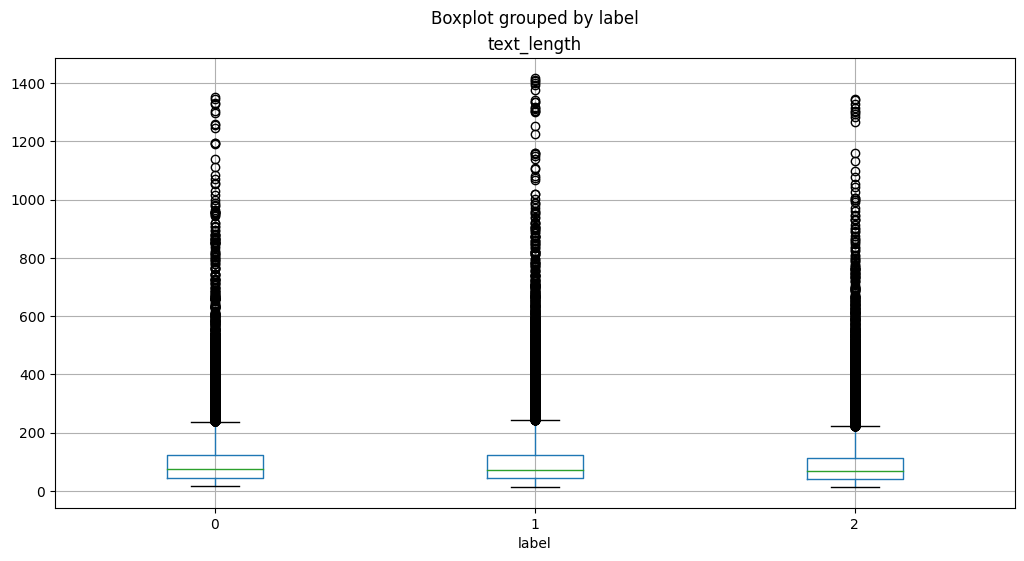

In [9]:
train_df.boxplot(column="text_length", by="label", figsize=(12, 6))

## トークン化
コンピュータは、入力として生の文字列を受け取ることができません。その代わりに、テキストがトークン化され、数値ベクトルとしてエンコードされていることが想定しています。

トークン化は、文字列をモデルで使用される最小単位に分解するステップです。

Transformerライブラリー は便利な```AutoTokenizer```クラスを提供しており、事前学習済みモデルに関連つけられたトークナイザーを素早く使用することができます。

## トークナイザの動作確認

In [10]:
from transformers import AutoTokenizer
model_ckpt = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

トークナイザを動かしてみましょう。

In [11]:
text="普段使いとバイクに乗るときのブーツ兼用として購入しました"

In [12]:
for line in train_df["text"][0].split('。'):
    print(line)

普段使いとバイクに乗るときのブーツ兼用として購入しました
見た目や履き心地は良いです
 しかし、２ヶ月履いたらゴム底が削れて無くなりました
また、バイクのシフトペダルとの摩擦で表皮が剥がれ、本革でないことが露呈しました
ちなみに防水とも書いていますが、雨の日は内部に水が染みます
 安くて見た目も良く、履きやすかったのですが、耐久性のなさ、本革でも防水でも無かったことが残念です
結局、本革の防水ブーツを買い直しました



In [13]:
sample_text_encoded = tokenizer(train_df["text"][0])
sample_text_encoded

{'input_ids': [2, 9406, 3276, 13, 10602, 7, 11838, 900, 5, 20806, 23540, 50, 2630, 15, 3913, 10, 8, 16493, 49, 6934, 28512, 18166, 9, 3614, 2992, 8, 373, 6, 25, 2779, 26909, 3318, 9007, 5366, 14, 3346, 28461, 16, 27430, 3913, 10, 8, 106, 6, 10602, 5, 10334, 22757, 13, 5, 13245, 12, 311, 29742, 14, 7520, 13468, 6, 108, 1869, 12, 80, 45, 14, 3438, 30294, 15, 3913, 10, 8, 5501, 25997, 981, 2977, 16, 21, 2610, 14, 6, 3741, 5, 32, 9, 2804, 7, 326, 14, 4896, 28614, 2610, 8, 18002, 16, 16493, 28, 5735, 6, 6934, 28512, 2076, 187, 10, 5, 2992, 14, 6, 10284, 245, 5, 18, 26, 6, 108, 1869, 12, 28, 25997, 12, 28, 6013, 10, 45, 14, 25267, 2992, 8, 3351, 6, 108, 1869, 5, 25997, 20806, 11, 5098, 13153, 3913, 10, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

結果に```input_ids```と```attention_mask```が含まれます。
- input_ids: 数字にエンコードされたトークン
- attention_mask: モデルで有効なトークンかどうかを判別するためのマスクです。無効なトークン（例えば、PADなど）に対しては、attention_maskを$0$として処理します。

トークナイザの結果は数字にエンコードされているため、トークン文字列を得るには、```convert_ids_to_tokens```を用います。

In [14]:
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)
print(tokens)

['[CLS]', '普段', '使い', 'と', 'バイク', 'に', '乗る', 'とき', 'の', 'ブーツ', '兼用', 'として', '購入', 'し', 'まし', 'た', '。', '見た目', 'や', '履', '##き', '心地', 'は', '良い', 'です', '。', 'しかし', '、', '2', 'ヶ月', '履い', 'たら', 'ゴム', '底', 'が', '削', '##れ', 'て', '無くなり', 'まし', 'た', '。', 'また', '、', 'バイク', 'の', 'シフト', 'ペダル', 'と', 'の', '摩擦', 'で', '表', '##皮', 'が', '剥', '##がれ', '、', '本', '革', 'で', 'ない', 'こと', 'が', '露', '##呈', 'し', 'まし', 'た', '。', 'ちなみに', '防水', 'とも', '書い', 'て', 'い', 'ます', 'が', '、', '雨', 'の', '日', 'は', '内部', 'に', '水', 'が', '染', '##み', 'ます', '。', '安く', 'て', '見た目', 'も', '良く', '、', '履', '##き', 'やす', '##かっ', 'た', 'の', 'です', 'が', '、', '耐久', '性', 'の', 'な', 'さ', '、', '本', '革', 'で', 'も', '防水', 'で', 'も', '無かっ', 'た', 'こと', 'が', '残念', 'です', '。', '結局', '、', '本', '革', 'の', '防水', 'ブーツ', 'を', '買い', '直し', 'まし', 'た', '。', '[SEP]']


文の開始が[CLS]、文の終了(実際は複数系列の切れ目)が[SEP]という特殊なトークンとなっています。

## データセット全体のトークン化

教師データのサイズが大きいのため、学習するのはかなり時間がかかりますので、ここでは一部の教師データしか使わない。

In [15]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [16]:
dataset.reset_format()

In [17]:
shuffled_train_data = dataset['train'].shuffle(seed=42)
# Define the size of the subset you want to obtain, e.g., 10%
subset_size = int(0.1 * len(shuffled_train_data))
# Extract the subset
subset = shuffled_train_data.select(range(subset_size))

In [18]:
dataset["train"]=subset

In [19]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [20]:
import pandas as pd
sample_encoded = dataset_encoded["train"][0]
pd.DataFrame(
    [sample_encoded["input_ids"]
     , sample_encoded["attention_mask"]
     , tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])],
    ['input_ids', 'attention_mask', "tokens"]
).T

,input_ids,attention_mask,tokens
0,2,1,[CLS]
1,57,1,4
2,181,1,つ
3,2630,1,購入
4,15,1,し
...,...,...,...
507,0,0,[PAD]
508,0,0,[PAD]
509,0,0,[PAD]
510,0,0,[PAD]


## 分類器の実装

### 事前学習モデルの導入

Transformerライブラリは事前学習モデルの使用ため```AutoModel```クラスを提供します。

```AutoModel```クラスはトークンエンコーディングを埋め込みに変換し、エンコーダスタックを経由して**最後の**隠れ状態を返します。

特に、```AutoModelForSequenceClassification```はテキスト分類専用のクラスになります。


```{margin}
深層学習は大量の行列計算を伴うため、大量の行列計算や浮動小数点の演算を同時に高速に処理できるGPUが必要されます。PyTorchはGPUをサポートしております。
```

In [27]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
inputs = tokenizer("普段使いとバイクに乗るときのブーツ兼用として購入しました", return_tensors="pt") # pytorch tensorに変換するためにreturn_tensors="pt"を指定
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.2150,  0.8152,  0.0885]], device='cuda:0'), hidden_states=None, attentions=None)


### 学習の準備

学習時に性能指標を与える必要があるため、それを関数化して定義しておきます。

In [37]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

```Trainer```クラスを初期化する際には、```TrainingArguments```という訓練に関する様々な設定値の集合を引数に与えることで、訓練の設定に関する細かい調整が可能です。

In [38]:
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = "sample-text-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

Trainerクラスで実行します。

In [40]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.592500,0.480344,0.805667,0.802639
2,0.391400,0.500137,0.813000,0.811704


TrainOutput(global_step=1500, training_loss=0.4919612833658854, metrics={'train_runtime': 604.2412, 'train_samples_per_second': 39.719, 'train_steps_per_second': 2.482, 'total_flos': 6314722025472000.0, 'train_loss': 0.4919612833658854, 'epoch': 2.0})

### モデル精度の検証 

学習済みのモデルを他のデータセットに適用します。

In [42]:
preds_output = trainer.predict(dataset_encoded["validation"])

混同行列でモデルの精度を検証します。

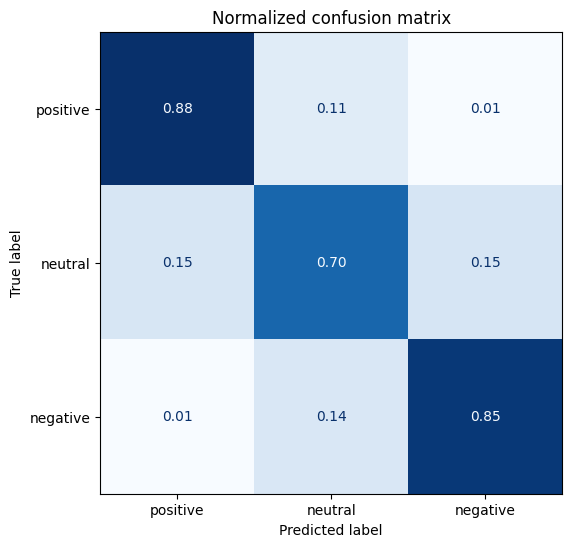

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["validation"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

### モデル保存

In [ ]:
id2label = {}
for i in range(dataset["train"].features["label"].num_classes):
    id2label[i] = dataset["train"].features["label"].int2str(i)

label2id = {}
for i in range(dataset["train"].features["label"].num_classes):
    label2id[dataset["train"].features["label"].int2str(i)] = i

trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

In [44]:
trainer.save_model(f"./Data/sample-text-classification-bert")

### 学習済みモデルの読み込み

In [33]:
new_tokenizer = AutoTokenizer\
    .from_pretrained(f"./Data/sample-text-classification-bert")

new_model = (AutoModelForSequenceClassification
    .from_pretrained(f"./Data/sample-text-classification-bert")
    .to(device))

サンプルテキストで推論の結果を確認します。

In [42]:
text1="使い物にならない"
text2="とても気に入った"

In [43]:
import numpy as np

inputs = new_tokenizer(text1, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds

array([2])

In [44]:
inputs = new_tokenizer(text2, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds

array([0])